## Individual Household Electric Power Consumption

The goal of this notebook is to use forecasting techniques on the Individual Household Electric Power Consumption Dataset.

Infos on the dataset:

Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.

Dataset source: https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption

This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months).
Notes: 

1.(global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.


2.The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.



## Data Exploration 
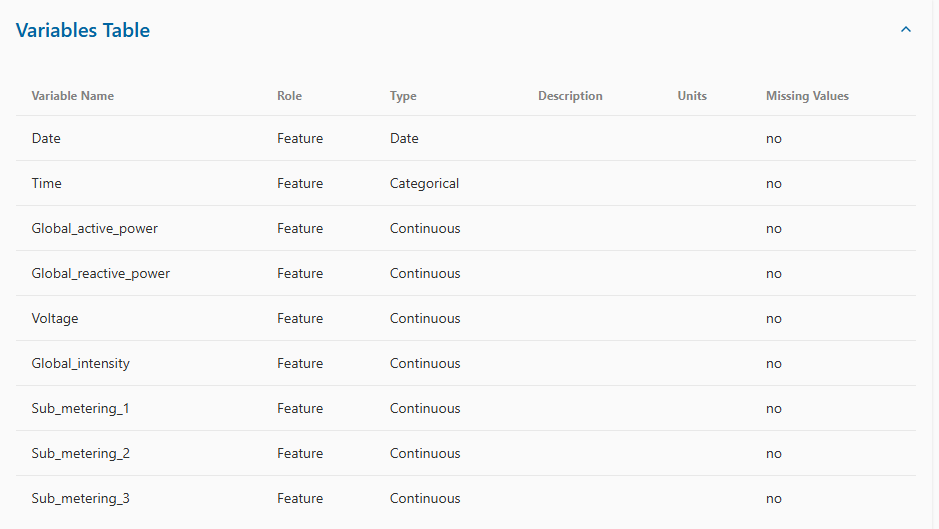

In [66]:
# Importing the dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [67]:
# Load dataset
file_path = "household_power_consumption/household_power_consumption.txt"  # Update with your actual path
df = pd.read_csv(file_path, sep=';', low_memory=False, na_values=['?'])

In [68]:
#  Convert Date & Time to Datetime Format
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df = df.drop(columns=['Date', 'Time'])  # Drop original columns
df = df.set_index('datetime')  # Set datetime as index
df = df.astype(float)  # Convert all columns to float

In [69]:
print(df[df.isna().any(axis=1)].count)

<bound method DataFrame.count of                      Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-21 11:23:00                  NaN                    NaN      NaN   
2006-12-21 11:24:00                  NaN                    NaN      NaN   
2006-12-30 10:08:00                  NaN                    NaN      NaN   
2006-12-30 10:09:00                  NaN                    NaN      NaN   
2007-01-14 18:36:00                  NaN                    NaN      NaN   
...                                  ...                    ...      ...   
2010-09-28 19:09:00                  NaN                    NaN      NaN   
2010-09-28 19:10:00                  NaN                    NaN      NaN   
2010-09-28 19:11:00                  NaN                    NaN      NaN   
2010-09-28 19:12:00                  NaN                    NaN      NaN   
2010-10-24 15:35:00                  NaN               

In [70]:
# df = df.interpolate()  # Linear interpolation to fill missing values
df = df.dropna()  # Drop remaining NaN values

In [71]:
df_resampled = df.resample('h').mean()  # Aggregates to hourly average
df_resampled

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667
...,...,...,...,...,...,...,...
2010-11-26 17:00:00,1.725900,0.061400,237.069667,7.216667,0.0,0.000000,12.866667
2010-11-26 18:00:00,1.573467,0.053700,237.531833,6.620000,0.0,0.000000,0.000000
2010-11-26 19:00:00,1.659333,0.060033,236.741000,7.056667,0.0,0.066667,0.000000


In [72]:
df_resampled['hour'] = df_resampled.index.hour
df_resampled['day_of_week'] = df_resampled.index.dayofweek
df_resampled['month'] = df_resampled.index.month
df_resampled['weekend'] = (df_resampled.index.weekday >= 5).astype(int)

In [73]:
df_resampled

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,day_of_week,month,weekend
datetime,,,,,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,17,5,12,1
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667,18,5,12,1
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333,19,5,12,1
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333,20,5,12,1
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667,21,5,12,1
...,...,...,...,...,...,...,...,...,...,...,...
2010-11-26 17:00:00,1.725900,0.061400,237.069667,7.216667,0.0,0.000000,12.866667,17,4,11,0
2010-11-26 18:00:00,1.573467,0.053700,237.531833,6.620000,0.0,0.000000,0.000000,18,4,11,0
2010-11-26 19:00:00,1.659333,0.060033,236.741000,7.056667,0.0,0.066667,0.000000,19,4,11,0


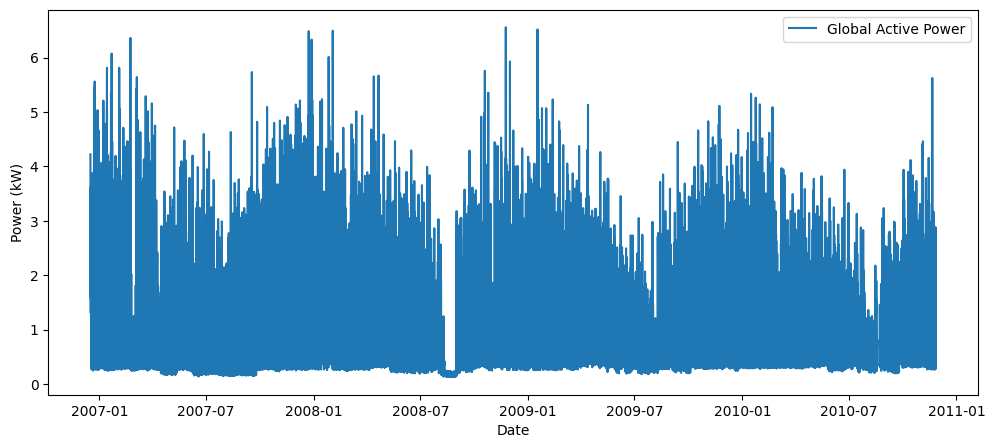

In [74]:
plt.figure(figsize=(12, 5))
plt.plot(df_resampled.index, df_resampled['Global_active_power'], label='Global Active Power')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()

In [75]:
# target = 'Global_active_power'  # This is what we want to predict
# X = df_resampled[[target]]  # Univariate time series
# train_size = int(len(X) * 0.8)  # Use 80% for training
# train, test = X.iloc[:train_size], X.iloc[train_size:]

In [76]:
has_na = df_resampled.isna().any().any()  # Checks for NaN
has_inf = np.isinf(df_resampled).any().any()  # Checks for Inf

print(f"Contains NaN: {has_na}")  # Output: True
print(f"Contains Inf: {has_inf}")  # Output: True
df_filtered = df_resampled[(df_resampled.isna()).any(axis=1)]
print(df_filtered)

Contains NaN: True
Contains Inf: False
                     Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2007-04-28 01:00:00                  NaN                    NaN      NaN   
2007-04-28 02:00:00                  NaN                    NaN      NaN   
2007-04-28 03:00:00                  NaN                    NaN      NaN   
2007-04-28 04:00:00                  NaN                    NaN      NaN   
2007-04-28 05:00:00                  NaN                    NaN      NaN   
...                                  ...                    ...      ...   
2010-09-28 14:00:00                  NaN                    NaN      NaN   
2010-09-28 15:00:00                  NaN                    NaN      NaN   
2010-09-28 16:00:00                  NaN                    NaN      NaN   
2010-09-28 17:00:00                  NaN                    NaN      NaN   
2010-09-28 18:00:00                  NaN         

In [77]:
# Test stationarity on Global_active_power
result = adfuller(df_resampled['Global_active_power'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:', result[4])

if result[1] < 0.05:
    print("✅ Data is stationary (p < 0.05)")
else:
    print("❌ Data is NOT stationary (p >= 0.05)")


MissingDataError: exog contains inf or nans

## Arima Model

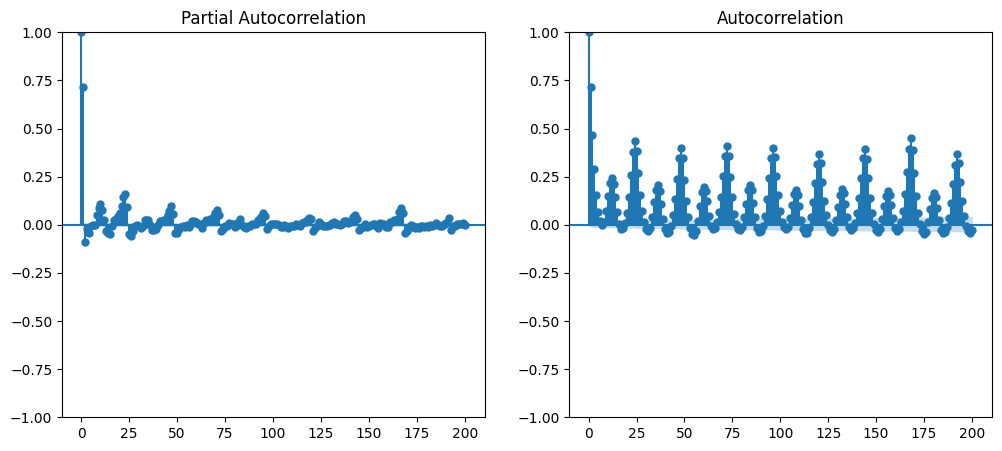

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_pacf(df_resampled['Global_active_power'].dropna(), lags=200, ax=plt.gca())  # PACF plot
plt.subplot(122)
plot_acf(df_resampled['Global_active_power'].dropna(), lags=200, ax=plt.gca())  # ACF plot
plt.show()

In [ ]:
# train_size = int(len(df_resampled) * 0.8)  # 80% for training
# train, test = df_resampled.iloc[:train_size], df_resampled.iloc[train_size:]

train_size = int(len(df_resampled) * 0.10)  # 80% for training
ignore_size = int(len(df_resampled) * 0.9)
test_size = int(len(df_resampled) * 0.1*0.2)
train, test = df_resampled.iloc[ignore_size:len(df_resampled)-test_size], df_resampled.iloc[len(df_resampled)-test_size:]
print(len(train), len(test))

2768 691


In [ ]:
from pmdarima import auto_arima

# Find the best (p, d, q) values automatically
auto_arima_model = auto_arima(
    train['Global_active_power'], 
    seasonal=True,  # Set to True for SARIMA (seasonal data)
    trace=True,  # Shows output for different (p, d, q) values
    # suppress_warnings=True,
    start_p=0,
    max_p=4,
    stepwise=True  # Efficient parameter search
)

# Get the best order
best_order = auto_arima_model.order
print(f"Best ARIMA order: {best_order}")

Performing stepwise search to minimize aic
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4081.181, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4332.590, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4302.794, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4290.743, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4330.591, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.59 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3838.553, Time=0.93 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3772.324, Time=1.67 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.64 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=3775.007, Time=1.40 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=3772.796, Time=2.62 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3770.497, Time=0.42 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=3836.581, T

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# order = best_order
order = (0,1,3)
# Train ARIMA model
model = ARIMA(train['Global_active_power'], order=best_order)
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

c:\Users\ihebe\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ihebe\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                SARIMAX Results                                
Dep. Variable:     Global_active_power   No. Observations:                 2768
Model:                  ARIMA(2, 1, 3)   Log Likelihood               -1870.898
Date:                 Tue, 18 Mar 2025   AIC                           3753.796
Time:                         16:15:29   BIC                           3789.349
Sample:                     07-05-2010   HQIC                          3766.637
                          - 10-29-2010                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3056      0.072     18.123      0.000       1.164       1.447
ar.L2         -0.5115      0.038    -13.612      0.000      -0.585      -0.438
ma.L1         -1.6184      0.073    -22.301 

c:\Users\ihebe\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


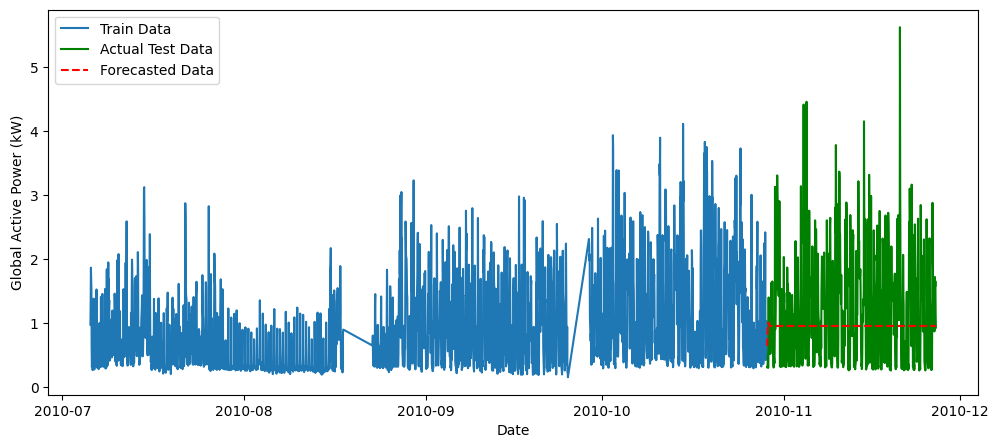

In [ ]:
forecast_steps = len(test)  # Predict same length as test set
forecast = model_fit.forecast(steps=forecast_steps)

# Create forecast date range
forecast_index = test.index  # Use test set's timestamps

# Convert to DataFrame
forecast_df = pd.DataFrame({'Forecast': forecast}, index=forecast_index)

# Plot actual vs. forecasted values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(train.index, train['Global_active_power'], label='Train Data')
plt.plot(test.index, test['Global_active_power'], label='Actual Test Data', color='green')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecasted Data', linestyle='dashed', color='red')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

In [ ]:
forecast_df

,Forecast
datetime,
2010-10-29 03:00:00,0.649357
2010-10-29 04:00:00,0.797433
2010-10-29 05:00:00,0.906846
2010-10-29 06:00:00,0.973952
2010-10-29 07:00:00,1.005596
...,...
2010-11-26 17:00:00,0.960920
2010-11-26 18:00:00,0.960920
2010-11-26 19:00:00,0.960920


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate error metrics
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')

ValueError: y_true and y_pred have different number of output (11!=1)